<img src="https://github.com/NOAA-OWP/gval/raw/main/docs/images/gval_light_mode.png" style="float:left">

# Categorical Comparisons

In [2]:
import rioxarray as rxr
import gval

## Load Datasets

It is preferred to use masking and scaling by default.  If your original data does not have nodata or does not have nodata assigned, please assign using: `rio.set_nodata(<your_nodata_value>)`

In [3]:
candidate = rxr.open_rasterio('candidate_map_two_class_categorical.tif', mask_and_scale=True)
benchmark = rxr.open_rasterio('benchmark_map_two_class_categorical.tif', mask_and_scale=True)

## Run GVAL Categorical Compare

An example of running the entire process with one command using minimal arguments is deomnstrated below.

In [4]:
agreement_map, crosstab_table, metric_table = candidate.gval.categorical_compare(benchmark,
                                                                                 positive_categories=[2],
                                                                                 negative_categories=[0, 1])

## Output

#### Agreement Map

The agreement map compares the encodings of the benchmark map and candidate map using a "comparison function" to then output unique encodings.  In this particular case the "Szudzik" comparison function was used by default since no argument was passed in for the `comparison_function` argument.  The Szudzik function is defined below:

$$
c = \text{candidate value} \\
b = \text{benchmark value} \\
f(x)= 
\begin{cases}
    c^{2} + c + b,& \text{if } c\geq b\\
    b^{2} + c,              & \text{otherwise}
\end{cases}
$$

The resulting map allows a user to visualize these encodings as follows:

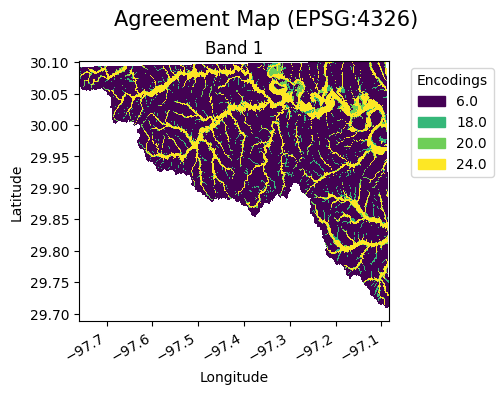

In [5]:
agreement_map.gval.cat_plot(title="Agreement Map")

#### Cross-tabulation Table

A cross-tabulation table displays the frequency of each class in the presence of another within the spatial unit of interest. The sample indices are denoted by the band column. The combination of candidate and benchmark map values are denoted. Additionally, the resulting agreement map values for each combination are shown. The counts column denotes the frequencies of occurrence and can then be used to compute categorical metrics.

In [6]:
crosstab_table

,band,candidate_values,benchmark_values,agreement_values,counts
0,1,1.0,0.0,6.0,10345720.0
1,1,2.0,0.0,20.0,512277.0
2,1,1.0,2.0,18.0,639227.0
3,1,2.0,2.0,24.0,2473405.0


#### Metric Table

A metric table contains information about the unit of analysis, (a single band in this case), and selected categorical metrics.  This is done by specifying the positive and negative categories of each dataset and then choosing the statistics of interest.  Since we did not provide the `metrics` argument GVAL computed all of the available categorical statistics.  (<b>Note: if there is no negative class encoding all statistics requiring true negatives will be skipped.</b>)

In [7]:
metric_table

,band,fn,fp,tn,tp,accuracy,critical_success_index,f_score,false_discovery_rate,false_negative_rate,...,fowlkes_mallows_index,matthews_correlation_coefficient,negative_likelihood_ratio,negative_predictive_value,positive_likelihood_ratio,positive_predictive_value,prevalence,prevalence_threshold,true_negative_rate,true_positive_rate
0,1,639227.0,512277.0,10345720.0,2473405.0,0.917577,0.682336,0.811177,0.171578,0.205365,...,0.811352,0.758757,0.215534,0.941809,16.842723,0.828422,0.213711,0.195925,0.95282,0.794635


## Access to Individual GVAL Operations

Aside form running the entire process, it is possible to run each of the following steps individually: homogenizing maps, computing an agreement map, computing a cross-tabulation table, and computing a metric table. This allows for flexibility in workflows so that a user may use as much or as little functionality as needed.

### Homogenize Maps

Homogenization is intended to help prepare two disparate maps for comparison. Currently, homogenization handles three sets of functionality:

1) *Spatial alignment:* matching the CRS's and coordinates of candidate and benchmark xarray maps. By default, the benchmark map is used as the target of this alignment but the candidate map can also be selected.
2) *Data type alignment:* in order to avoid precision warnings in the comparisons, dtypes are set to the highest precision dtype of the two maps.
3) *Data format conversion:* a vector data format benchmark map as a Geopanda's DataFrame can be passed which will be converted to the same xarray object as the candidate map with the same CRS and coordinates.

In [8]:
candidate, benchmark = candidate.gval.homogenize(benchmark_map=benchmark,
                                                 target_map = "candidate")

The `target_map` can also be an alternate map:

In [9]:
target_map = rxr.open_rasterio('target_map_two_class_categorical.tif')
candidate, benchmark = candidate.gval.homogenize(benchmark_map=benchmark,
                                                 target_map = target_map)

The default is to resample using the "nearest" method.  Although not applicable for this case of categorical comparisons, one can change the `resampling` argument to use alternative resampling methods such as bilinear or cubic resampling.  These methods would be relevant in the case of continuous datasets.

### Agreement Map

The "szudzik" comparison function is run by default if the `comparison_function` argument is not provided, but one may use the "cantor" pairing function, or a custom callable.

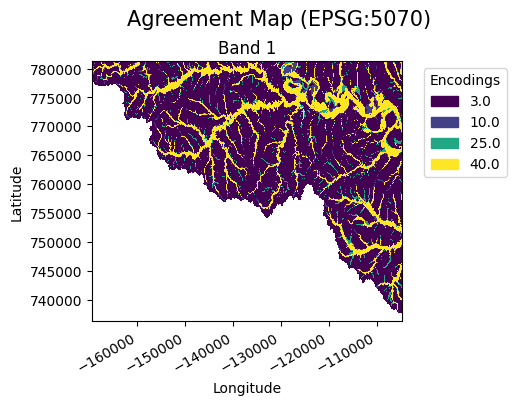

In [10]:
agreement_map = candidate.gval.compute_agreement_map(benchmark_map=benchmark, 
                                                     comparison_function='cantor')

agreement_map.gval.cat_plot(title="Agreement Map")

#### Pairing Dictionary

A pairing dictionary can be provided by the user to allow more control when specifying the agreement value outputs.

A pairing dictionary has keys that are tuples corresponding to every unique combination of values in the candidate and benchmark, respectively. The values represent the agreement values for each combination. An example pairing dictionary for the candidate values [1,2] and benchmark values [0, 2] is provided below.  A user has full control over the encodings including the combinations of nodata values (which are in this case np.nan).

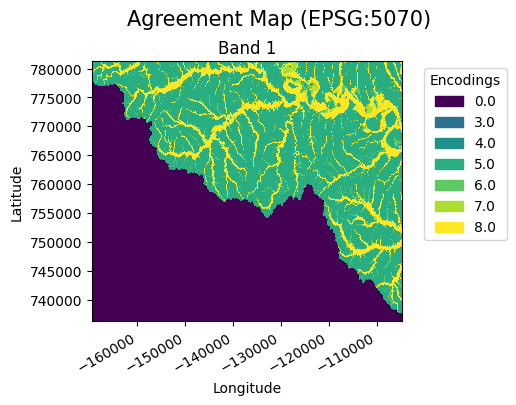

In [11]:
import numpy as np

pairing_dict = {
    (np.nan,np.nan): 0,
    (np.nan, 0): np.nan,
    (np.nan, 2): np.nan,
    (1, np.nan): 3,
    (2, np.nan): 4,
    (1, 0): 5,
    (1, 2): 6, 
    (2, 0): 7,
    (2, 2): 8
}

agreement_map = candidate.gval.compute_agreement_map(benchmark_map=benchmark,
                                                     comparison_function='pairing_dict',
                                                     pairing_dict=pairing_dict)

agreement_map.gval.cat_plot(title="Agreement Map")

Instead of building a pairing dictionary, a user can pass the unique candidate and benchmark values to use and a pairing dictionary will be built for the user. In this case nodata values are not included and will automatically become the nodata value instead of an encoding.

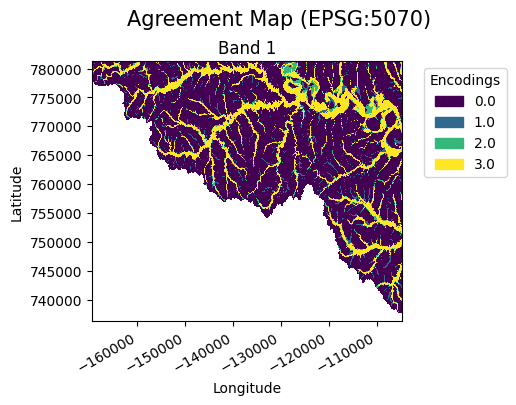

In [12]:
agreement_map = candidate.gval.compute_agreement_map(benchmark_map=benchmark, 
                                                     comparison_function='pairing_dict',
                                                     allow_candidate_values=[1, 2],
                                                     allow_benchmark_values=[0, 2])

agreement_map.gval.cat_plot(title="Agreement Map")

#### Registration of Custom Functions

In this case we register the arbitrary pairing function `multiply` with the name "multi" and then vectorize it.  `Multiply` can also be passed in as a function in the `comparison_function` argument

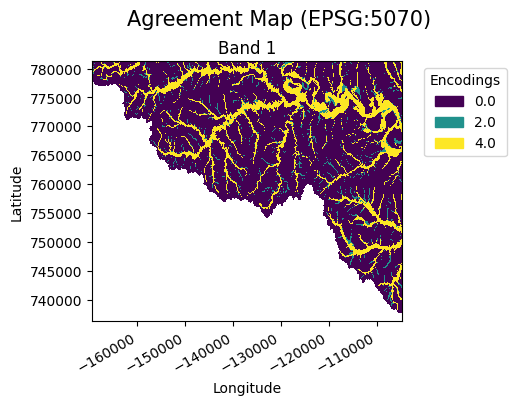

In [13]:
from gval import Comparison
from numbers import Number

@Comparison.register_function(name='multi', vectorize_func=True)
def multiply(c: Number, b: Number) -> Number:
    return c * b

agreement_map = candidate.gval.compute_agreement_map(benchmark_map=benchmark, 
                                                     comparison_function="multi")

agreement_map.gval.cat_plot(title="Agreement Map")

A user can also pick which candidate values or benchmark values to use by providing lists to the `allow_candidate_values` and `allow_benchmark_values` arguments.  Finally, a user can choose to write nodata to unmasked datasets with the `nodata` value, or to masked/scaled datasets with `encode_nodata`. 

### Cross-tabulation Table

When computing a crosstab table, a user may create an allow list for candidate/benchmark values just as done in the compute agreement map method.  They may also exclude a nodata value with `exclude_value` in the case that `mask_and_scale` is not applied when loading the original data files.

In [14]:
crosstab_table_allow = candidate.gval.compute_crosstab(benchmark,
                                                       allow_benchmark_values=[0, 2],
                                                       allow_candidate_values=[2],
                                                       comparison_function="multi"
                                                      )
crosstab_table_allow

,band,candidate_values,benchmark_values,agreement_values,counts
0,1,2.0,0.0,0.0,544392.0
1,1,2.0,2.0,4.0,2624301.0


### Metric Table

Although all categorical metrics are computed by default if no argument is provided, `metrics` can also take a list of the desired metrics and will only return metrics in this list.

In [15]:
metric_table_select = crosstab_table.gval.compute_categorical_metrics(negative_categories= [0, 1],
                                                                      positive_categories = [2],
                                                                      metrics=['true_positive_rate', 'prevalence'])
metric_table_select

,band,fn,fp,tn,tp,true_positive_rate,prevalence
0,1,639227.0,512277.0,10345720.0,2473405.0,0.794635,0.213711


Just like registering comparison functions, you are able to register a metric function on both a method and a class of functions.  Below is registering a metric function:

In [16]:
from gval import CatStats

@CatStats.register_function(name="error_balance", vectorize_func=True)
def error_balance(fp: Number, fn: Number) -> float:
    return fp / fn

The following is registering a class of metric functions. In this case, the names associated with each function will respond to each method's name.

In [17]:
@CatStats.register_function_class(vectorize_func=True)
class MetricFunctions:
    
    @staticmethod
    def arbitrary1(tp: Number, tn: Number) -> float:
        return tp + tn
    
    @staticmethod
    def arbitrary2(tp: Number, tn: Number) -> float:
        return tp - tn

All of these functions are now callable as metrics:

In [18]:
metric_table_register = crosstab_table.gval.compute_categorical_metrics(negative_categories= None,
                                                                        positive_categories = [2],
                                                                        metrics=['error_balance', 
                                                                                 'arbitrary1', 
                                                                                 'arbitrary2'])

In [19]:
metric_table_register

,band,fn,fp,tn,tp,error_balance
0,1,639227.0,512277.0,NaN,2473405.0,0.801401


## Save Output

Finally, a user can take the results and save them to a directory of their choice.  The following is an example of saving the agreement map and then the metric table:

In [20]:
# output agreement map
agreement_file = 'agreement_map.tif'
metric_file = 'metric_file.csv'

agreement_map.rio.to_raster(agreement_file)
metric_table.to_csv(metric_file)